In [1]:
import math
import torch
import torchaudio
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
#from torch.utils.tensorboard import SummaryWriter

In [105]:
def plot_noise_distribution(noise, predicted_noise):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))  # Create three subplots
    
    # Plot GT Noise
    axes[0].plot(noise.cpu().numpy()[0,0], label='GT Noise L', linewidth=0.5, marker='o', markersize=1)
    axes[0].plot(noise.cpu().numpy()[0,1], label='GT Noise R', linewidth=0.5, marker='o', markersize=1)
    axes[0].grid()
    axes[0].legend()
    
    # Plot Predicted Noise
    axes[1].plot(predicted_noise.cpu().numpy()[0,0], label='Pred Noise L', linewidth=0.5, marker='o', markersize=1)
    axes[1].plot(predicted_noise.cpu().numpy()[0,1], label='Pred Noise R', linewidth=0.5, marker='o', markersize=1)
    axes[1].grid()
    axes[1].legend()
    
    # Plot Noise Distribution
    axes[2].hist(noise.cpu().numpy().flatten(), density=True, alpha=0.8, label="Ground Truth Noise")
    axes[2].hist(predicted_noise.cpu().numpy().flatten(), density=True, alpha=0.8, label="Predicted Noise")
    axes[2].legend()
    
    plt.show()

In [34]:
from random import randint
dataset = []
#writer = SummaryWriter("runs/08_12_unconditioned")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

directory = '/nas/home/jalbarracin/datasets/hrir_st'
dataset = []
left_channels = []
right_channels = []

for files in os.listdir(directory):
    f = os.path.join(directory, files)
    wave, sr = torchaudio.load(f, normalize=False)

    left_channel = wave[0].to(dtype=torch.float32)
    right_channel = wave[1].to(dtype=torch.float32)
    
    left_channels.append(left_channel)
    right_channels.append(right_channel)
    
    dataset.append(wave)
    

all_left_channels = torch.cat(left_channels,dim=-1)
all_right_channels = torch.cat(right_channels,dim=-1)

mean_left = all_left_channels.mean(dim=-1)  # Compute mean along the last dimension
std_left = all_left_channels.std(dim=-1)

mean_right = all_right_channels.mean(dim=-1)
std_right = all_right_channels.std(dim=-1)

# Normalize each stereo audio sample
normalized_dataset = [(wave - torch.tensor([mean_left, mean_right]).unsqueeze(-1)) / torch.tensor([std_left, std_right]).unsqueeze(-1) for wave in dataset]

Using device: cuda


In [35]:
print(f"Dataset length: {len(normalized_dataset)}")
print(f"Sample channels and length: {normalized_dataset[0].shape}")

Dataset length: 3096
Sample channels and length: torch.Size([2, 256])


In [36]:
def collate_fn(batch):
    # Assuming each element in batch is a tensor of shape (2, 256)
    return torch.stack([item.squeeze(0) for item in batch])

In [37]:
BATCH_SIZE = 1 # len(dataset) // 4
dataloader = torch.utils.data.DataLoader(
    normalized_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    collate_fn=collate_fn,
)

In [38]:
audio_test = next(iter(dataloader))[0]
print(audio_test.shape)

torch.Size([2, 256])


In [84]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps = 300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps
        
        """
        if 
            betas = [0.1, 0.2, 0.3, ...]
        then
            alphas = [0.9, 0.8, 0.7, ...]
            alphas_cumprod = [0.9, 0.9 * 0.8, 0.9 * 0.8, * 0.7, ...]
            
        
        """ 
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        
    def forward(self, x_0, t, device="cpu"):
        """
        x_0: (B, C, H, W)
        t: (B,)
        """
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)
            
        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)
        
        return mean + variance, noise.to(device)
    
    @torch.no_grad()
    def backward(self, x, t, model, **kwargs):
        """
        Calls the model to predict the noise in the image and returns 
        the denoised image. 
        Applies noise to this image, if we are not in the last step yet.
        """
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, **kwargs) / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise 
            return mean + variance

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        """
        pick the values from vals
        according to the indices stored in `t`
        """
        result = values.gather(-1, t.cpu())
        """
        if 
        x_shape = (5, 3, 64, 64)
            -> len(x_shape) = 4
            -> len(x_shape) - 1 = 3
            
        and thus we reshape `out` to dims
        (batch_size, 1, 1, 1)
        
        """
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [85]:
diffusion_model = DiffusionModel()

noisy audio:  torch.Size([10, 2, 256])


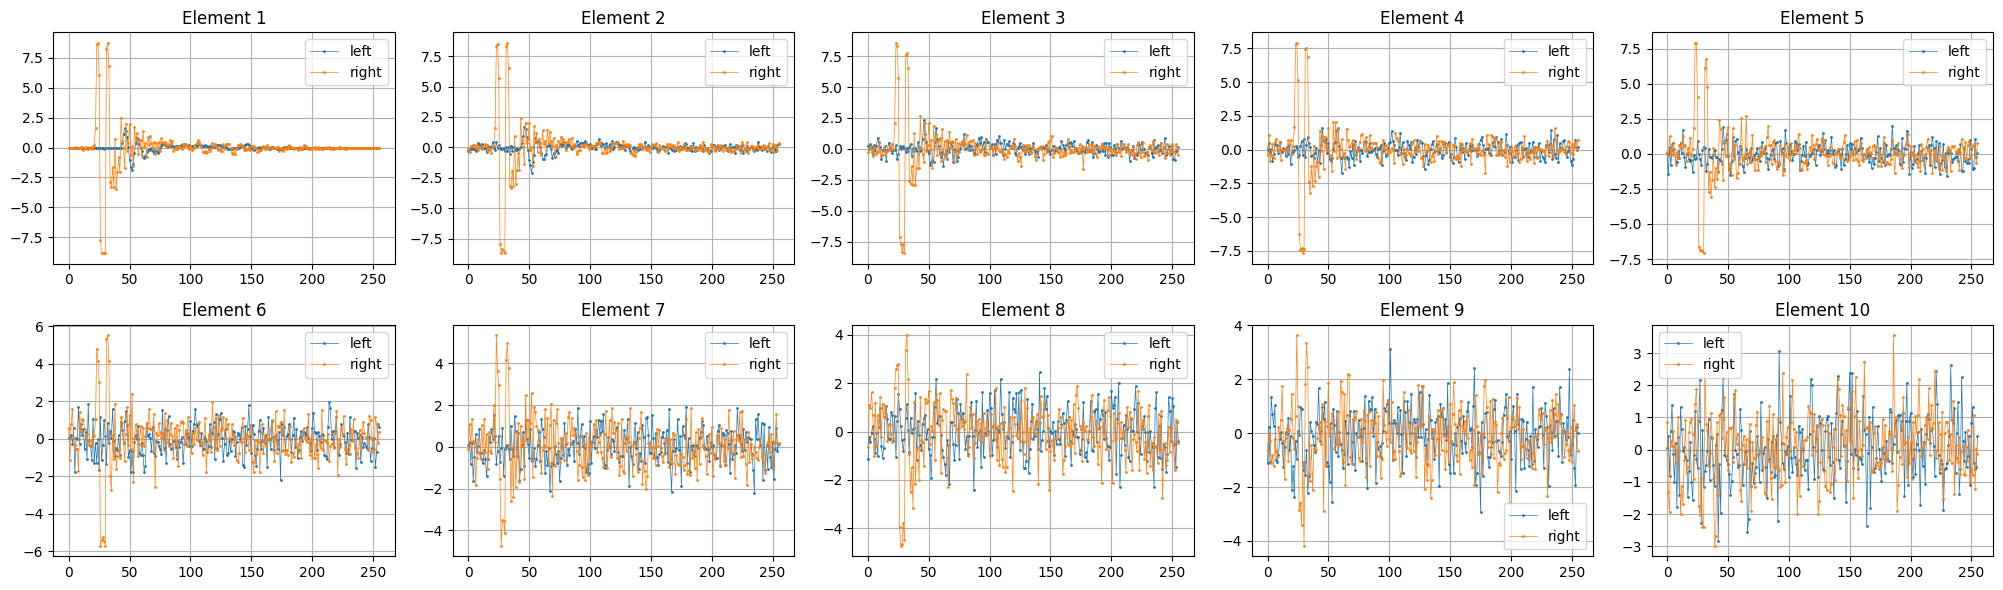

In [86]:
NO_DISPLAY_IMAGES = 10
torch_audio_batch = torch.stack([audio_test] * NO_DISPLAY_IMAGES)
t = torch.linspace(0, diffusion_model.timesteps - 1, NO_DISPLAY_IMAGES).long()
noisy_audio_batch, _ = diffusion_model.forward(torch_audio_batch, t, device)
print("noisy audio: ", noisy_audio_batch.shape)

# Move the tensor to the CPU
noisy_audio_batch_cpu = noisy_audio_batch.cpu().numpy()

# Plot the 10 elements in two rows with 5 elements each
plt.figure(figsize=(20, 6))

for i in range(NO_DISPLAY_IMAGES):
    plt.subplot(2, 5, i + 1)
    plt.plot(noisy_audio_batch_cpu[i, 0], label='left', linewidth=0.5, marker='o', markersize=1)
    plt.plot(noisy_audio_batch_cpu[i, 1], label='right', linewidth=0.5, marker='o', markersize=1)
    plt.grid()
    plt.title(f'Element {i + 1}')
    plt.legend()

plt.tight_layout()
plt.show()


In [87]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv1d(2 * in_ch, out_ch, kernel_size=3, padding=1)
            self.transform = nn.ConvTranspose1d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)
        else:
            self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size=3, padding=1)
            self.transform = nn.Conv1d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bnorm1 = nn.BatchNorm1d(out_ch)
        self.bnorm2 = nn.BatchNorm1d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        # Remove the last dimension
        #print("x before", x.shape)
        x = x.squeeze(2)
        #print("x shape",x.shape)
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))  # Adjust here
        #print("After conv1 shape:", h.shape)
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last dimension
        time_emb = time_emb.unsqueeze(-1)
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        #print("After conv2 shape:", h.shape)
        # Down or Upsample
        return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
       
        return embeddings

class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        audio_channels = 2  # Adjust for stereo audio
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 2  # Adjust for stereo audio
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # Initial projection
        self.conv0 = nn.Conv1d(audio_channels, down_channels[0], kernel_size=3, padding=1)  # Adjust here

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i + 1], time_emb_dim) \
                                    for i in range(len(down_channels) - 1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i + 1], time_emb_dim, up=True) \
                                  for i in range(len(up_channels) - 1)])

        # Output layer
        self.output = nn.Conv1d(up_channels[-1], out_dim, kernel_size=1)

    def forward(self, x, timestep):
        # Embed time
        t = self.time_mlp(timestep)
        #print("Time embedding shape:", t.shape)
        # Initial conv
        x = self.conv0(x)  
        #print("After conv0 shape:", x.shape)
        # Unet
        residual_inputs = []
        for i, down in enumerate(self.downs):
            #print("hola")
            x = down(x, t)
            #print(f"After downsampling block {i} shape:", x.shape)
            residual_inputs.append(x)
        for i, up in enumerate(self.ups):
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
            #print(f"After upsampling block {i} shape:", x.shape)
        # Assuming the final output layer is 1D
        return self.output(x)


# Example usage
model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  18569314


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv1d(2, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (transform): Conv1d(128, 128, kernel_size=(4,), stride=(2,), padding=(1,))
      (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (bnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (transform): Conv1d(256, 256, kernel_si

In [107]:
NO_EPOCHS = 2001
PRINT_FREQUENCY = 400
LR = 0.001
BATCH_SIZE = 128
VERBOSE = True
device = "cuda" if torch.cuda.is_available() else "cpu"
unet = SimpleUnet()
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

---
Epoch: 0 | Train Loss 0.8101396560668945


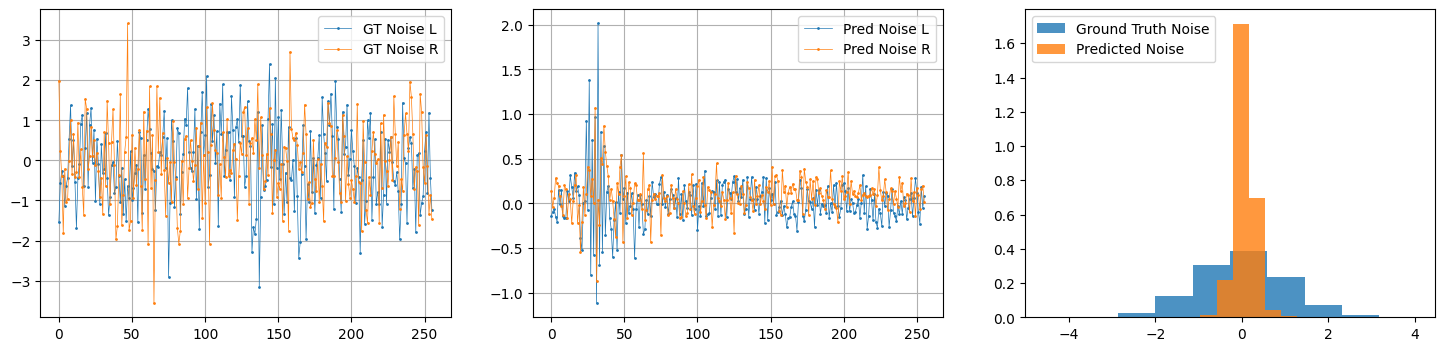

---
Epoch: 400 | Train Loss 0.0800628811120987


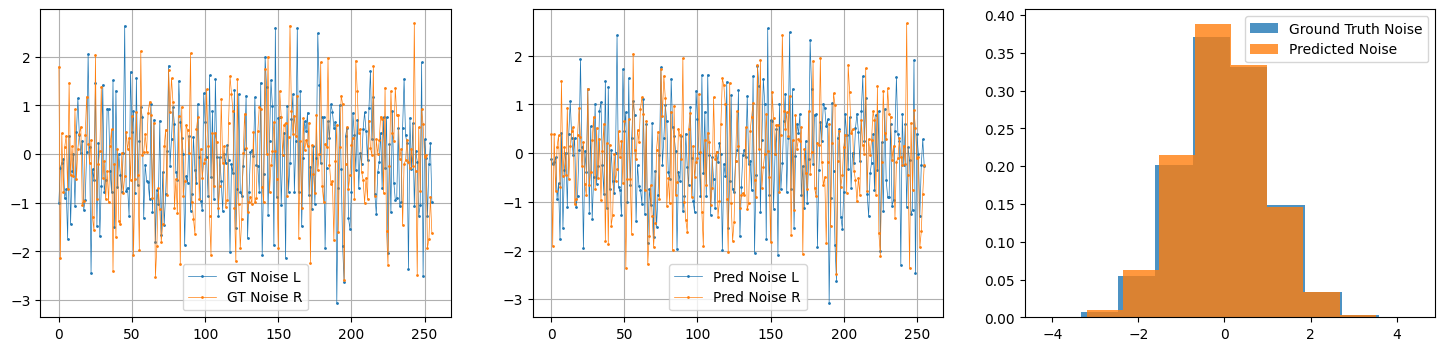

---
Epoch: 800 | Train Loss 0.06500203162431717


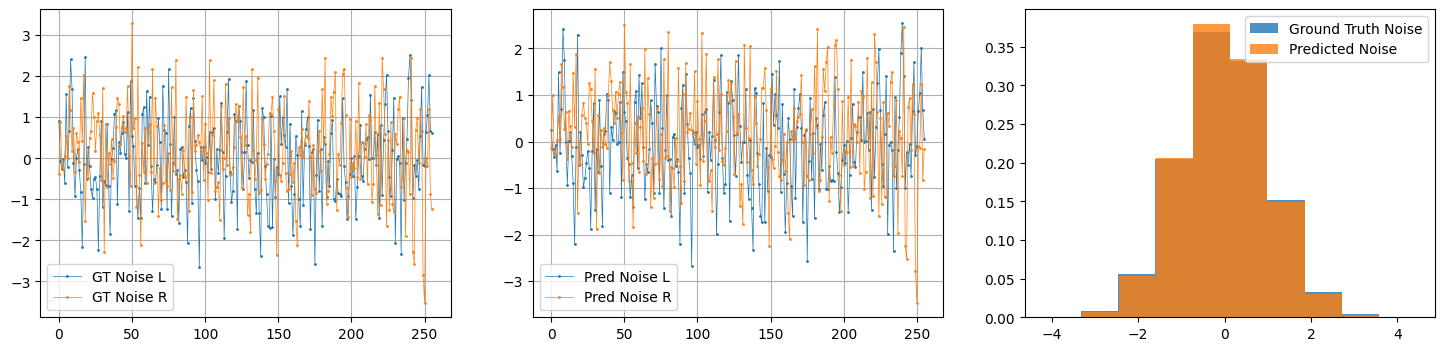

---
Epoch: 1200 | Train Loss 0.052760057151317596


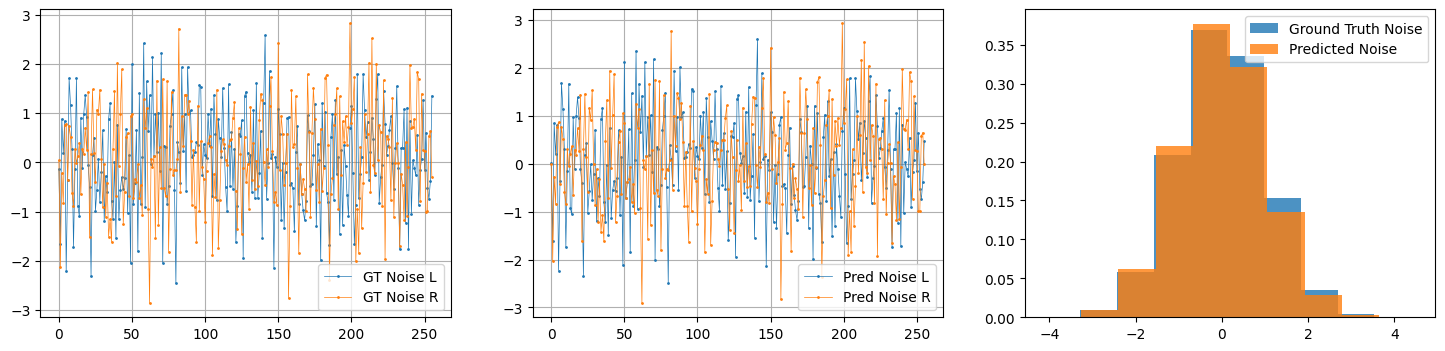

---
Epoch: 1600 | Train Loss 0.04435000568628311


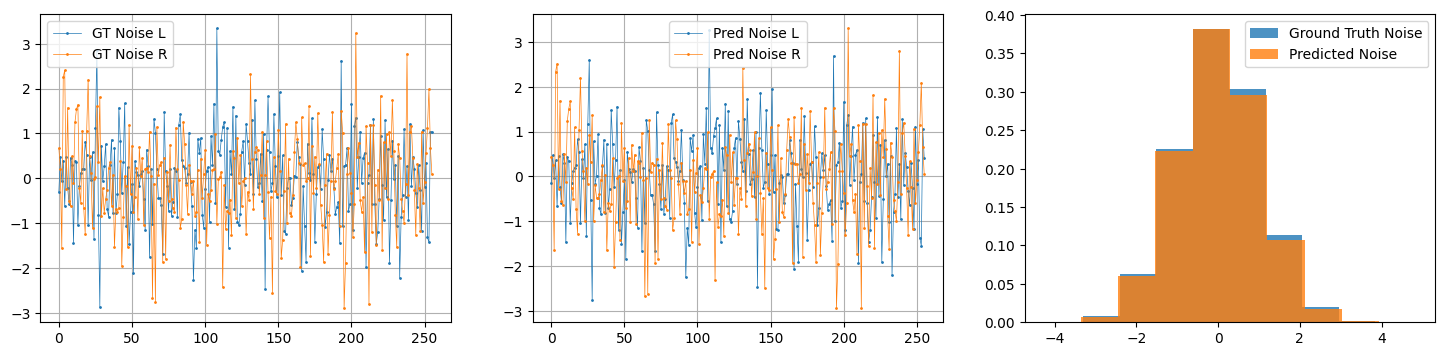

---
Epoch: 2000 | Train Loss 0.04693226516246796


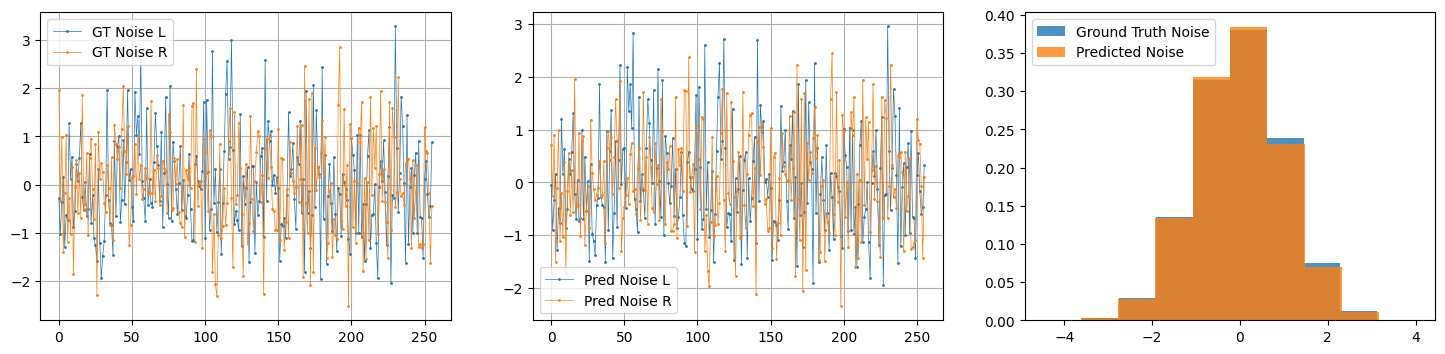

In [108]:

for epoch in range(NO_EPOCHS):
    mean_epoch_loss = []
    audio_test = audio_test.to(device)
    batch = torch.stack([audio_test] * BATCH_SIZE).to(device)
    t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
    batch_noisy, noise = diffusion_model.forward(batch, t, device) 
    predicted_noise = unet(batch_noisy, t)
    
    optimizer.zero_grad()
    loss = torch.nn.functional.l1_loss(noise, predicted_noise) 
    mean_epoch_loss.append(loss.item())
    loss.backward()
    optimizer.step()
    
    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_distribution(noise, predicted_noise)

In [14]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [15]:
AUDIO_SIZE = 256

@torch.no_grad()
def sample_timestep(audio, t):
    """
    Calls the model to predict the noise in the audio and returns 
    the denoised audio. 
    Applies noise to this audio, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, audio.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, audio.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, audio.shape)
    #print("Audio shape:", audio.shape)
    # Call model (current audio - noise prediction)
    # Concatenate both channels along the channel dimension
    model_mean = sqrt_recip_alphas_t * (
        audio - betas_t * model(audio, t) / sqrt_one_minus_alphas_cumprod_t
    )

    posterior_variance_t = get_index_from_list(posterior_variance, t, audio.shape)

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(audio)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_audio():
    # Sample noise
    audio = torch.randn((1, 2, AUDIO_SIZE), device=device)  # Adjust for stereo audio
    plt.figure(figsize=(12, 2))
    plt.axis('off')
    num_audios = 5
    stepsize = int(T / num_audios)
    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        audio = sample_timestep(audio, t)
        # Clip the audio to a reasonable range (-1 to 1)
        #audio = torch.clamp(audio, -1.0, 1.0)
        #print(audio.shape)
        if i % stepsize == 0:
            plt.subplot(1, num_audios, int(i / stepsize) + 1)
            #print("audio shape:", audio.shape)
            #print("left:",len(audio[0][0]))
            #print("right:",len(audio[0][1]))
            #hrtf = np.asarray([audio[0][0],audio[0][1]]).swapaxes(-1,0)
            
            show_tensor_waveform(audio[0].detach().cpu())  # Display left channel
            #show_tensor_waveform(audio[0][1].detach().cpu())  # Display right channel
            #print("audio shape:", audio[0].shape)
            #print('lol')
            torchaudio.save(f'generated_st_audio.wav', audio[0].cpu(), 44100)  # Save the stereo audio
    plt.subplots_adjust(hspace=0.5)
    plt.show()


Epoch 0 | step 000 Loss: 0.8678234815597534 


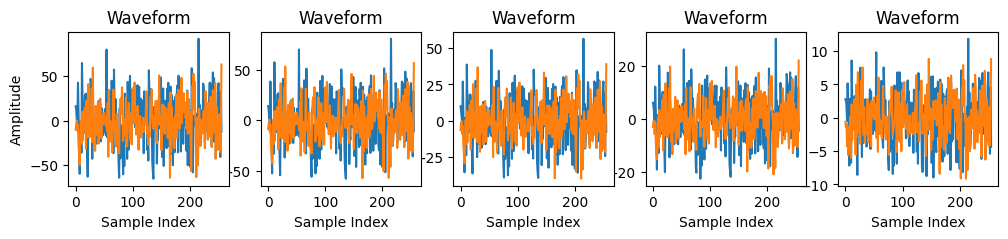

Epoch 5 | step 000 Loss: 0.16691705584526062 


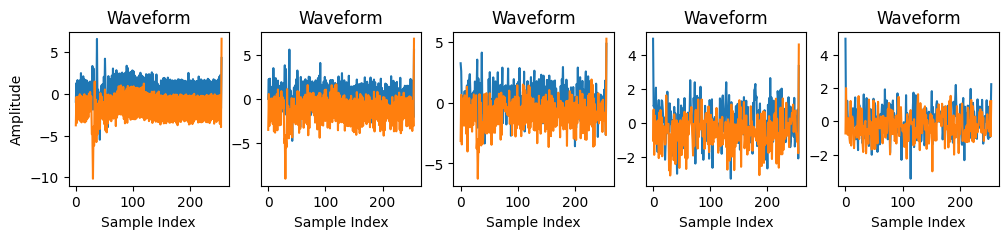

Epoch 10 | step 000 Loss: 0.14596736431121826 


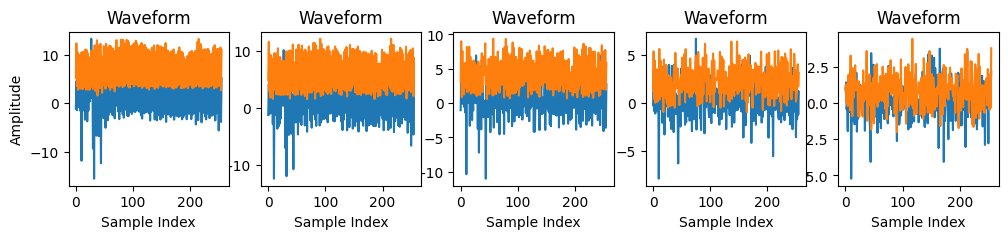

Epoch 15 | step 000 Loss: 0.22996658086776733 


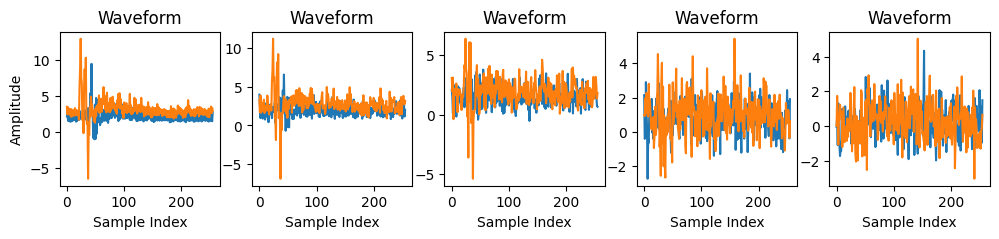

Epoch 20 | step 000 Loss: 0.2049480825662613 


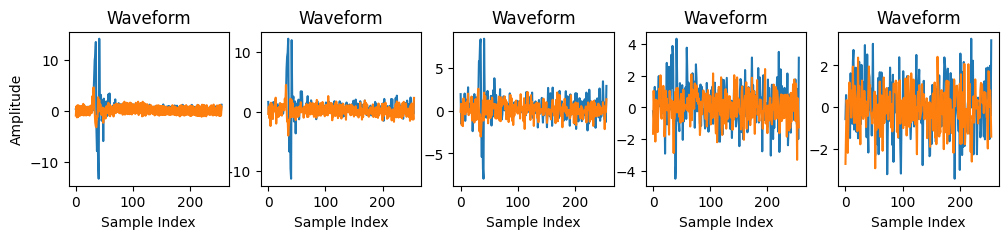

Epoch 25 | step 000 Loss: 0.11838633567094803 


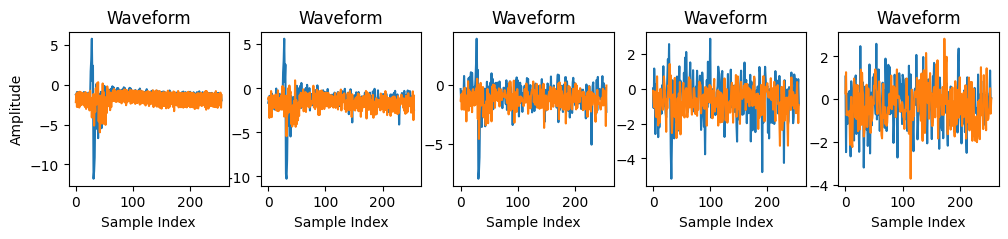

Epoch 30 | step 000 Loss: 0.19036146998405457 


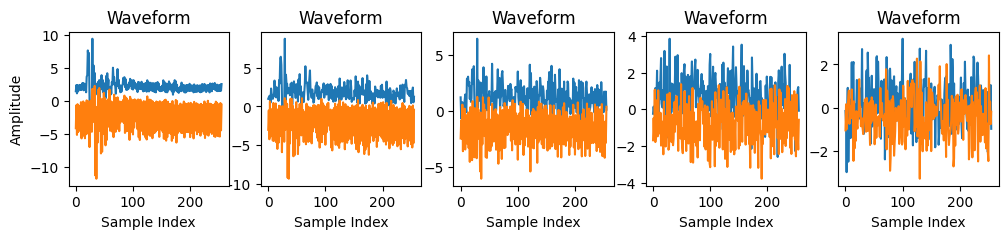

Epoch 35 | step 000 Loss: 0.14914923906326294 


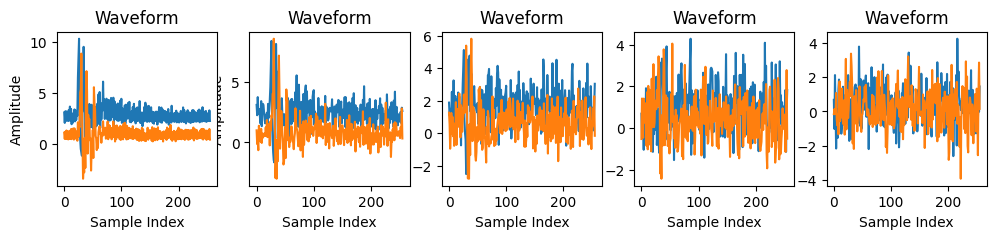

Epoch 40 | step 000 Loss: 0.1886342614889145 


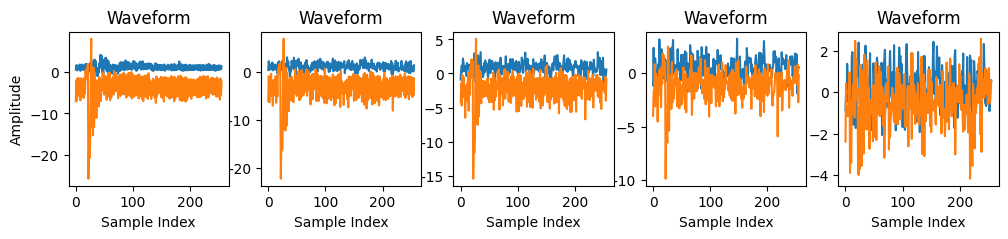

Epoch 45 | step 000 Loss: 0.1736387312412262 


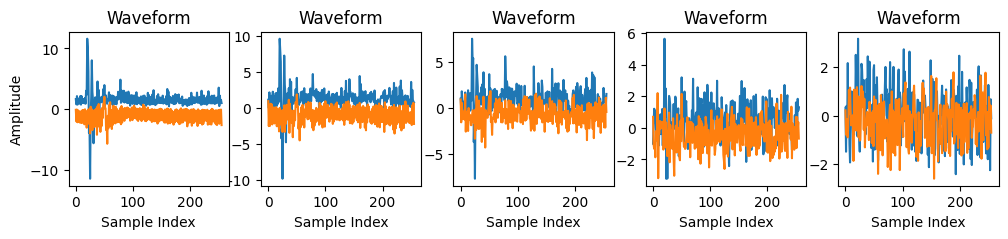

Epoch 50 | step 000 Loss: 0.1704094409942627 


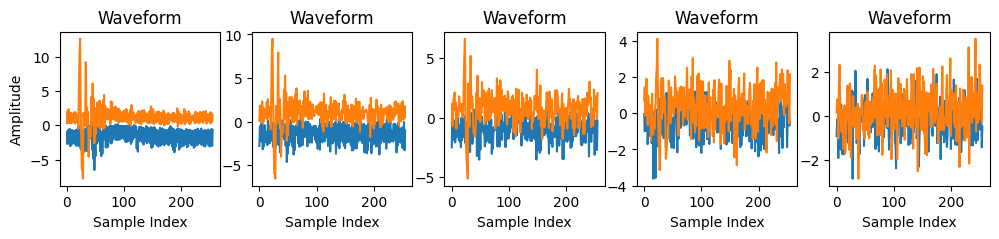

Epoch 55 | step 000 Loss: 0.12791013717651367 


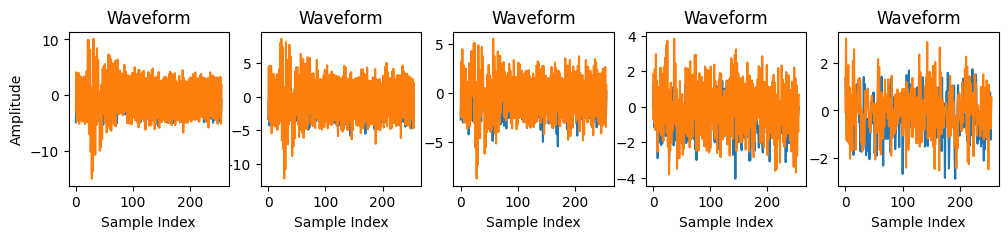

Epoch 60 | step 000 Loss: 0.08680175244808197 


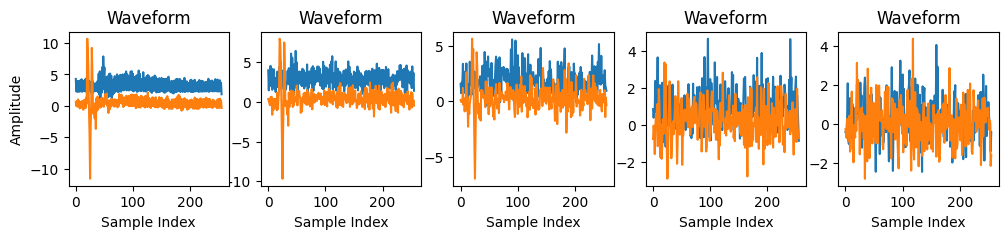

Epoch 65 | step 000 Loss: 0.11755891144275665 


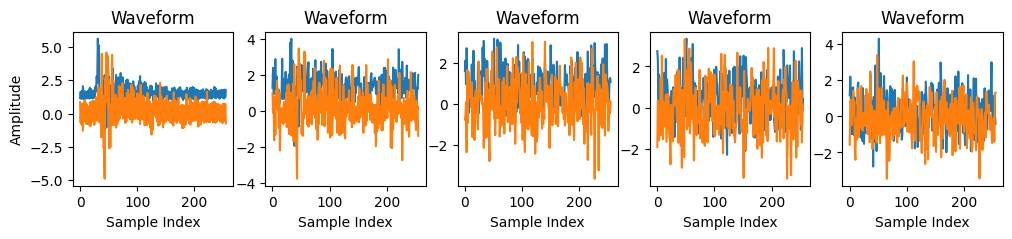

Epoch 70 | step 000 Loss: 0.3339982032775879 


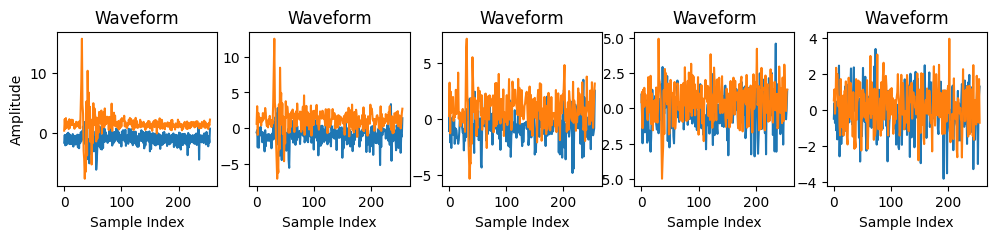

Epoch 75 | step 000 Loss: 0.09324266761541367 


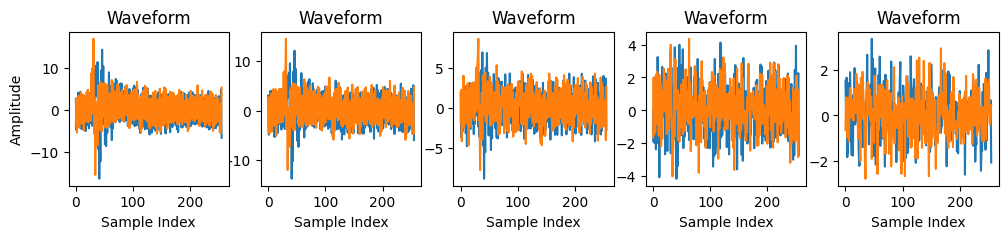

Epoch 80 | step 000 Loss: 0.20012600719928741 


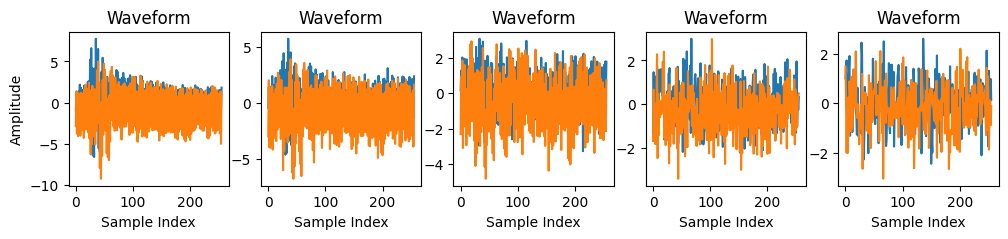

Epoch 85 | step 000 Loss: 0.21572181582450867 


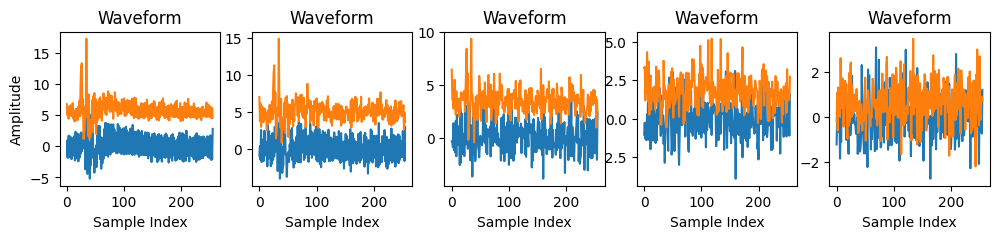

Epoch 90 | step 000 Loss: 0.10371610522270203 


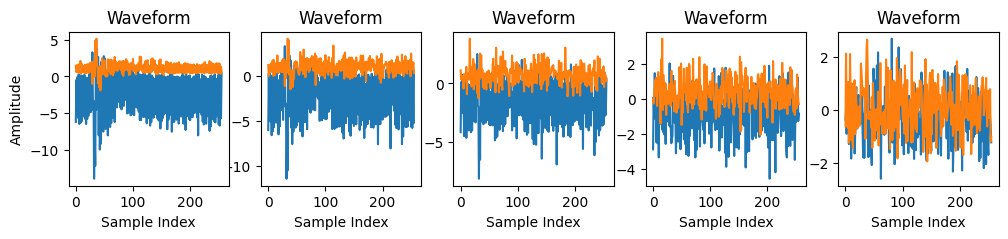

Epoch 95 | step 000 Loss: 0.15139862895011902 


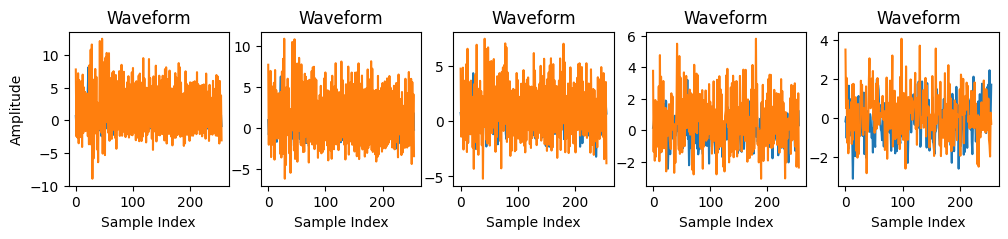

Epoch 100 | step 000 Loss: 0.07723855972290039 


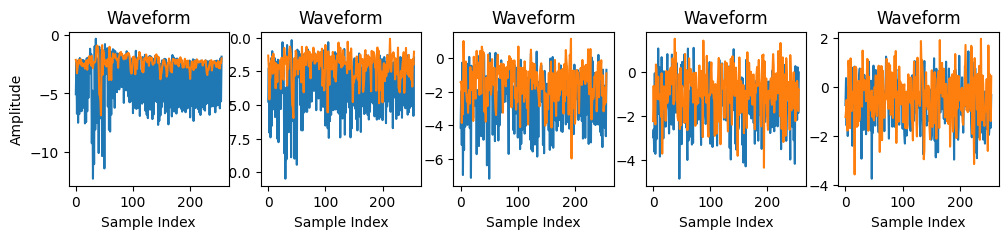

Epoch 105 | step 000 Loss: 0.08852769434452057 


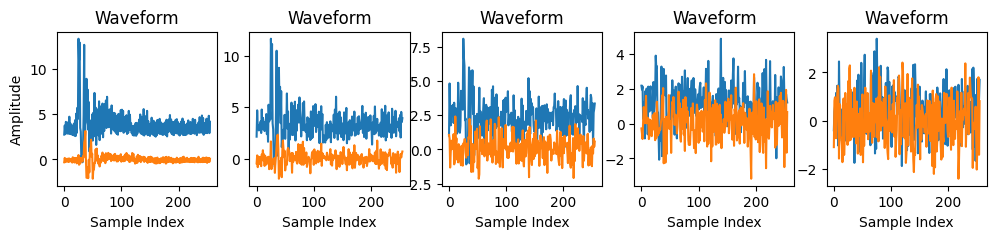

Epoch 110 | step 000 Loss: 0.07649455964565277 


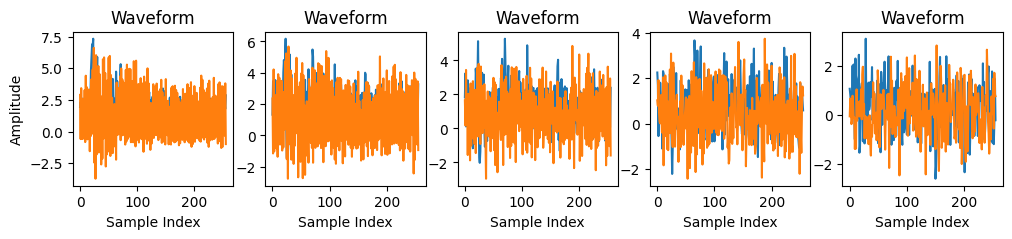

Epoch 115 | step 000 Loss: 0.14347457885742188 


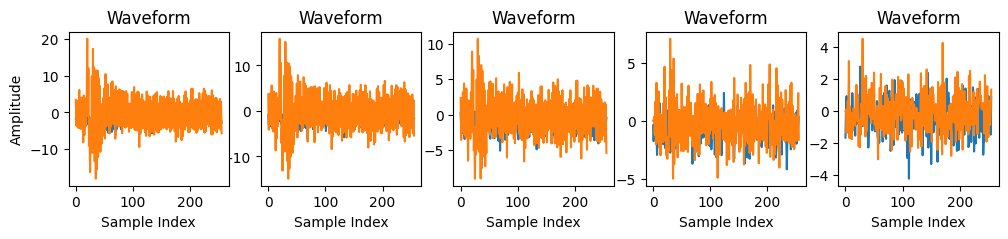

Epoch 120 | step 000 Loss: 0.0906258374452591 


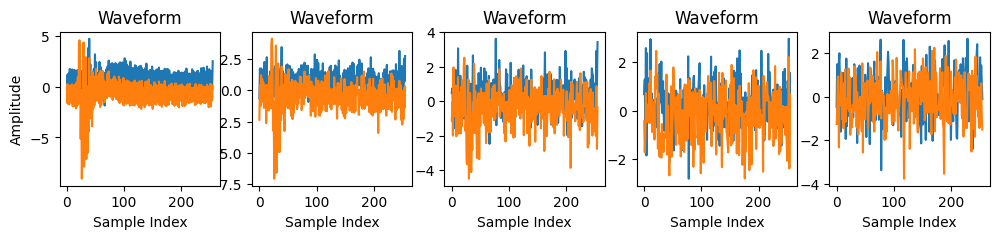

Epoch 125 | step 000 Loss: 0.2614082396030426 


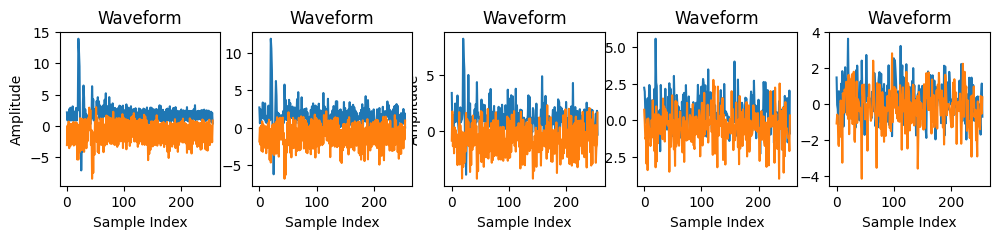

Epoch 130 | step 000 Loss: 0.14853829145431519 


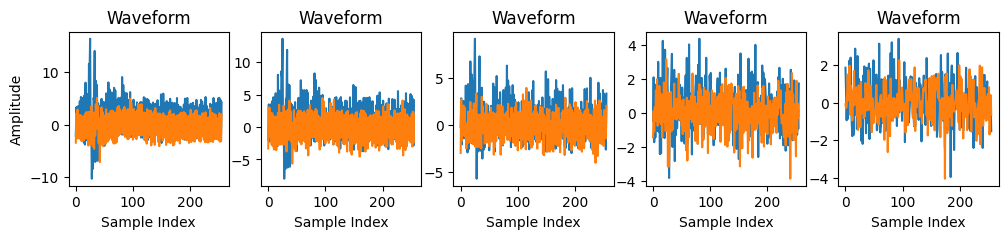

Epoch 135 | step 000 Loss: 0.1527218073606491 


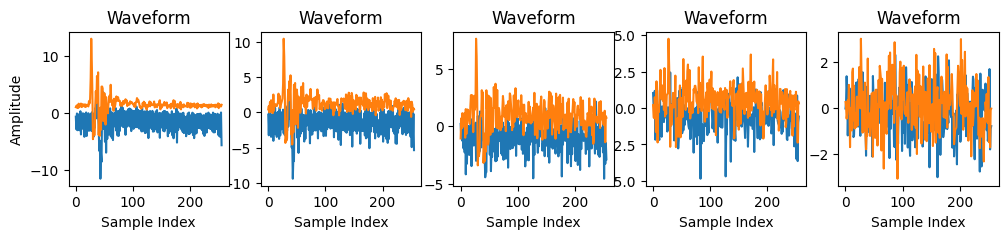

Epoch 140 | step 000 Loss: 0.3683207333087921 


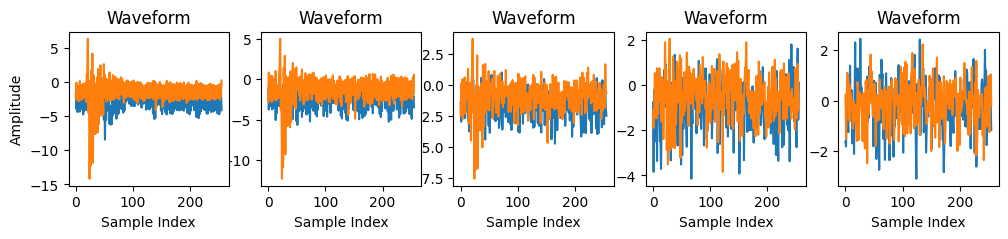

Epoch 145 | step 000 Loss: 0.5755035877227783 


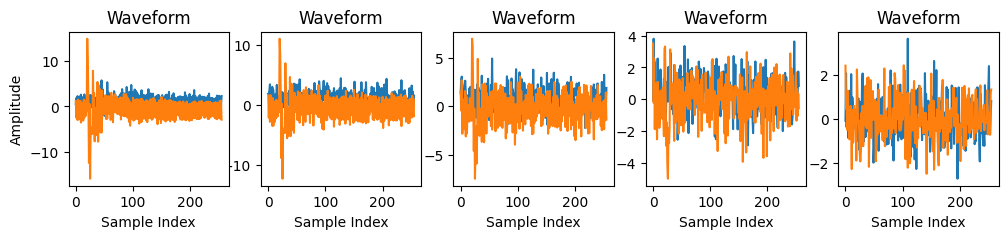

Epoch 150 | step 000 Loss: 0.13003762066364288 


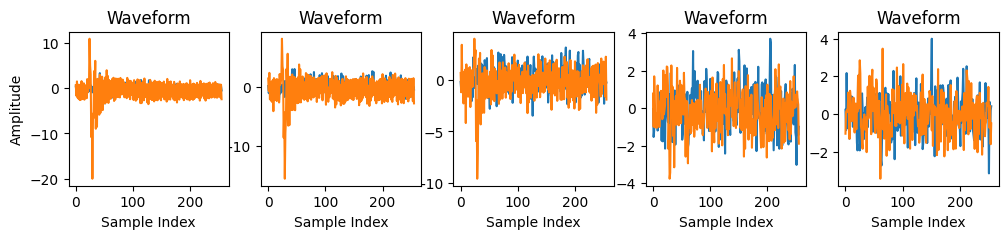

Epoch 155 | step 000 Loss: 0.09310773015022278 


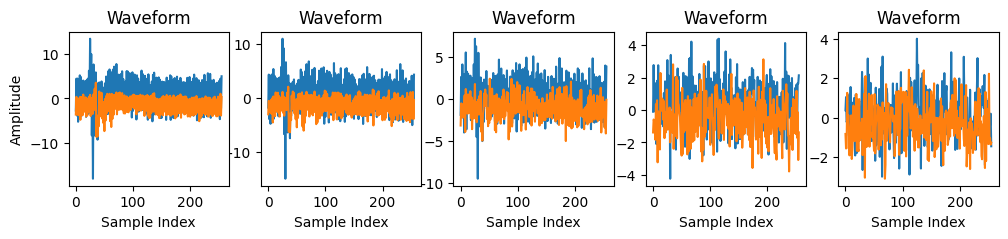

Epoch 160 | step 000 Loss: 0.11361376941204071 


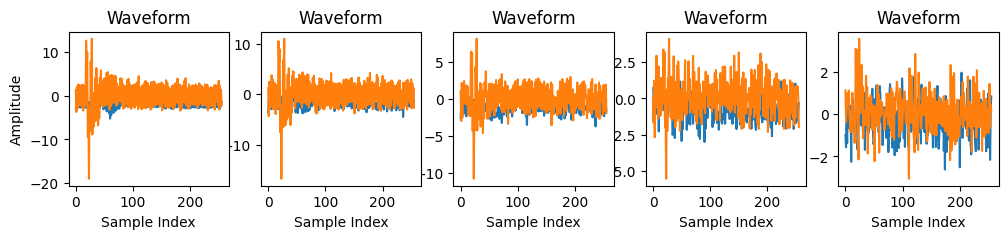

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.01)
epochs = 200

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        x_input = batch[0].unsqueeze(0) 
        #print("shape input", x_input.shape)
        loss = get_loss(model, x_input, t)
        #writer.add_scalar("Loss/train", loss, epoch)
        loss.backward()
        optimizer.step()

        if epoch % 5 == 0 and step == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            sample_plot_audio()
            
    
    # Save model and optimizer states after each epoch
    checkpoint_path = f"checkpoint_epoch_{epoch}.pt"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.item(),
    }, checkpoint_path)
    
writer.flush()
print("Training complete. Saved checkpoints.")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(256, 2)


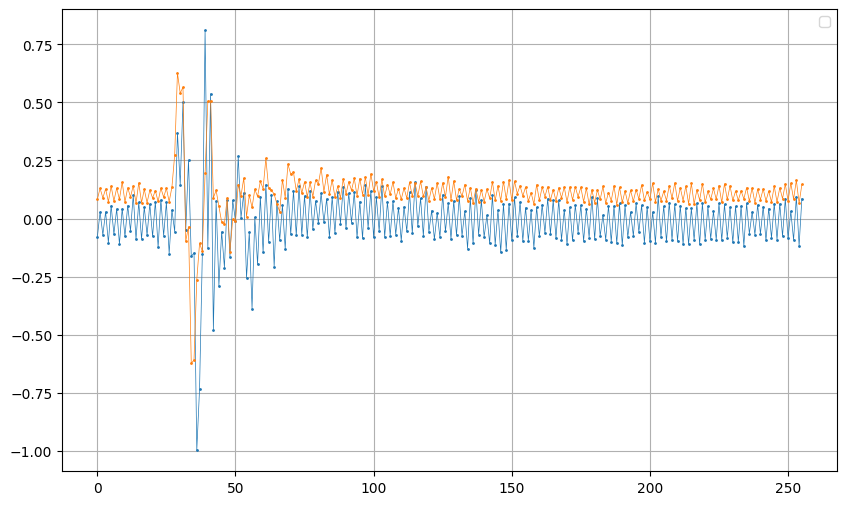

In [19]:
import soundfile as sf
#mse
generated_hrir, sr = sf.read('generated_st_audio.wav')
print(generated_hrir.shape)
plt.figure(figsize=(10,6))
plt.plot(generated_hrir, linewidth=0.5,  marker='o', markersize=1)
#plt.plot(generated_hrir[1], label='right', linewidth=0.5,  marker='o', markersize=1)
plt.grid()
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(256, 2)


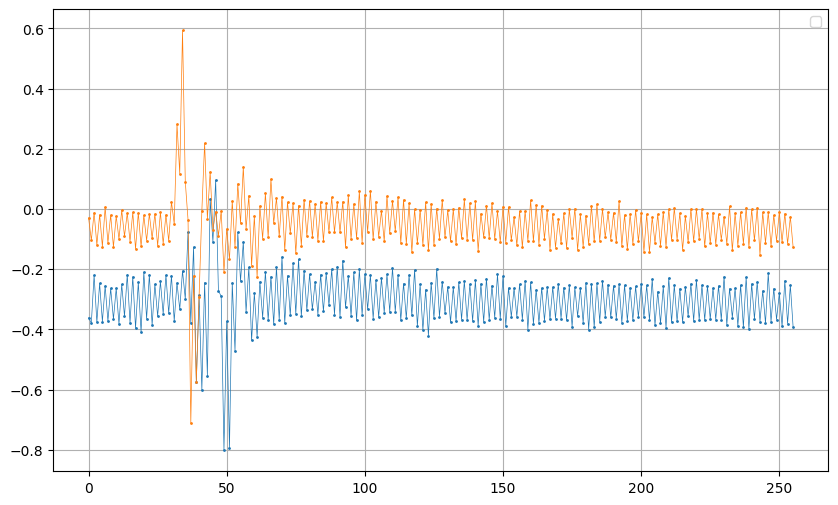

In [4]:
#l1
generated_hrir, sr = sf.read('/nas/home/jalbarracin/ddpm/results/21_nov/generated_st_audio.wav')
print(generated_hrir.shape)
plt.figure(figsize=(10,6))
plt.plot(generated_hrir, linewidth=0.5,  marker='o', markersize=1)
#plt.plot(generated_hrir[1], label='right', linewidth=0.5,  marker='o', markersize=1)
plt.grid()
plt.legend()
plt.show()

In [5]:
import scipy.signal
import IPython
test_signal, sr = sf.read('test_signal.wav')
print(test_signal.shape)
binaural_left = scipy.signal.fftconvolve(test_signal,generated_hrir[0])
binaural_right = scipy.signal.fftconvolve(test_signal,generated_hrir[1])
print(len(binaural_right))
print(len(binaural_left))
binaural_st = np.asarray([binaural_left,binaural_right]).swapaxes(-1,0)
sf.write('processed_audio_st.wav',binaural_st,44100)

(119190,)
119191
119191
